# 2021-11-15 Stabilized FE

## Last time

* Element restriction
* Finite element assembly
* Nonlinear problems
* LibCEED

## Today

* Community presentations
* Petrov-Galerkin stabilization
* Mass lumping for time dependent problems
* Examples of finite element interfaces

# Community presentations

## [Corey Murphey: SU2](https://github.com/cu-numpde/2021-community-clmurphey/raw/d8b8e0c1a3949ec32babe1cffd92eb851979a69a/2021-11-15-community-analysis-prezo/2021-community_analysis_prezo_CLM.pdf)

## Matthew Kolbe: QuantLib

## Tim Aiken: libCEED

In [52]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature

default(linewidth=4)

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis(P, Q, quadrature)
    x, _ = gausslobatto(P)
    q, w = quadrature(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end


function xnodal(x, P)
    nelem = length(x) - 1
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end

struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem; quadrature=gausslegendre)
        x, Et = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q, quadrature)
        new(P, Q, nelem, x, xn, Et, q, w, B, D)
    end
end

function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et'[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

fe_element (generic function with 1 method)

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [54]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    v
end

fe_residual (generic function with 1 method)

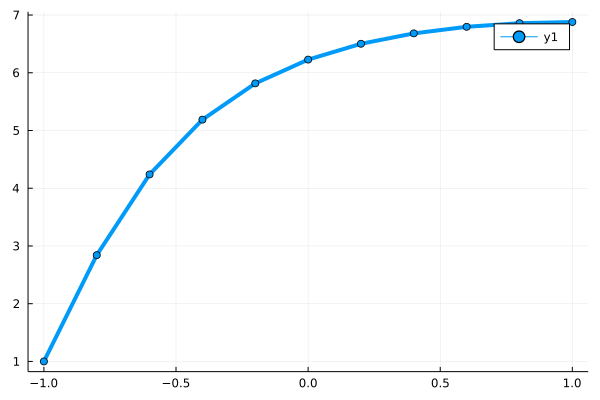

In [55]:
import NLsolve: nlsolve

fe = FESpace(3, 3, 5)
u0 = zero(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
plot(fe.xn, sol.zero, marker=:auto)

# Advection-diffusion (time independent)

\begin{align}
\mathbf w \cdot \nabla u - \nabla\cdot\big[ \kappa \nabla u \big] &= s & \int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u  &= \int_\Omega v s, \forall v
\end{align}

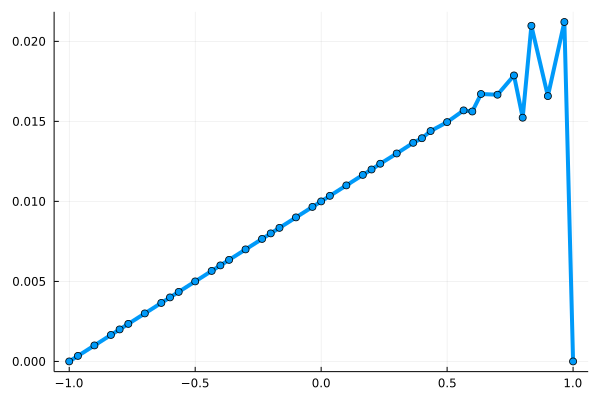

In [65]:
wind = 100
fq(q, u, Du) = wind .* Du -one.(u), 1 * Du

fe = FESpace(5, 5, 10)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)

# Artificial diffusion and Streamline Upwinding

Observation: the residual is large where diffusion is needed.

$$\int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s + \int_\Omega \tau^e (\mathbf w \cdot \nabla v) \big(\mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s\big)$$

## Examine what this does to advection

$$(\mathbf w \cdot \nabla v)(\mathbf w \cdot \nabla u) = \nabla v (\mathbf w \otimes \mathbf w) \nabla u$$

This is "pencil" shaped diffusion, only along the streamline. If $\tau^e$ is chosen appropriately, this will be enough diffusion to get a Peclet number of about 1 when it needs it.

## Optimal stabilization
A nodally exact solution for 1D advection.
$$ \tau^e = \frac{h}{2 \lVert \mathbf w \rVert} \Big( \coth Pe - \frac{1}{Pe} \Big)$$

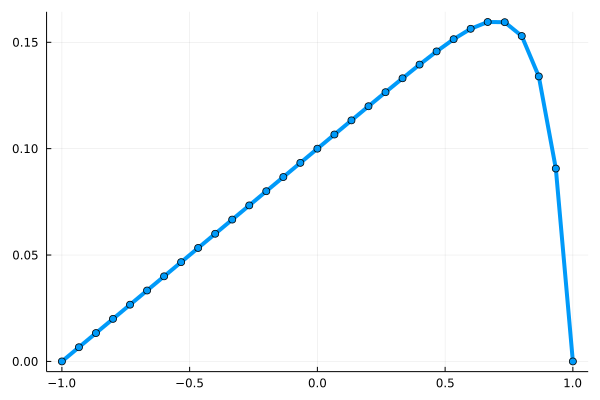

In [68]:
wind = 10; k = 1
fq(q, u, Du) = wind .* Du -one.(u), k * Du + tau * wind.^2 .* Du

n = 30; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
fe = FESpace(2, 2, n)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)

# Time dependent problems

1. Start with a time dependent problem in strong form
$$ u_t + \nabla\cdot (\mathbf w u - \kappa \nabla u) = 0 .$$
2. Multiply by a test function $v$ and integrate
$$ \int_\Omega \Big[ v u_t + \nabla v\cdot \big(\kappa \nabla u - \mathbf w u \big) - vs \Big] = 0, \forall v.$$
3. Discretize and assemble
$$ M u_t + A u - s = 0$$
4. Convert to explicit ODE form
$$ u_t = M^{-1} (-A u + s). $$

* Mass matrix $M$ has the same sparsity pattern as the physics $A$ -- direct solve costs the same.
  * Finite element methods must be explicit?
* $M$ is usually much better conditioned than $A$; solve in less than 10 CG iterations with Jacobi preconditioning.
* Replace $M$ with a diagonal approximation
  * $\operatorname{diag}(M)$ is inconsistent
  * row sums = "lumping"
  * use collocated Lobatto quadrature

# Collocated quadrature

In [69]:
dfq(q, u, du, Du, Ddu) = du, 0*Ddu

function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

norm(J1 - diagm(diag(J1))) = 1.0314997307155373e-16
norm(J2 - diagm(diag(J2))) = 0.07988743228160039
norm(sum(J2, dims = 2) - diag(J1)) = 4.638301540976035e-16


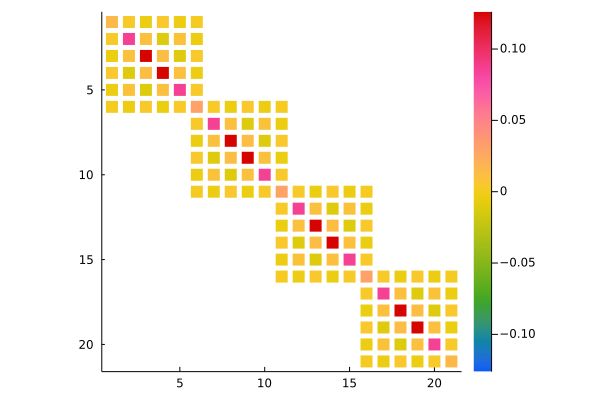

In [71]:
fe = FESpace(6, 6, 4, gausslobatto)
u0 = zero(fe.xn)
J1 = fe_jacobian(u0, fe, dfq, bci=[], bcv=[])
fe = FESpace(6, 6, 4, gausslegendre)
J2 = fe_jacobian(u0, fe, dfq, bci=[], bcv=[])
@show norm(J1 - diagm(diag(J1)))
@show norm(J2 - diagm(diag(J2)))
@show norm(sum(J2, dims=2) - diag(J1))
my_spy(J2)

# SUPG for time-dependent problems

$$\int_\Omega v \big( u_t + \mathbf w \cdot \nabla u \big) + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s + \int_\Omega \tau^e (\mathbf w \cdot \nabla v) \big(u_t + \mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s\big)$$

* There is a $u_t$ term in the stabilization, tested by a gradient of the test function. This means we can't create a simple explicit form
$$u_t = M^{-1} F(u)$$
* Some ad-hoc methods treat this term explicitly, which effectively lags this term. It can work, but limits the choice of time integrator and affects order of accuracy in time.
* One can use fully implicit methods with this formulation, usually written as $G(\dot u, u, t) = 0$. Generalized alpha (a second order scheme that can move continuously between midpoint and BDF2, which is L-stable) methods are popular.

* There is a strong  form $$\nabla\cdot(\kappa\nabla u)$$ appearing in stabilization.
* For linear elements, this is typically zero on each element.
  * Ignore the term (popular) or reconstruct it using neighbor cells (implementation complexity) and/or projection (extra work/communication).
* High order elements
  * If $\kappa$ is constant, $\kappa \nabla\cdot\nabla u$ can be implemented using second derivatives of the basis functions.
  * Or via projection
  * Should $\tau^e$ be constant or variable over the element?